In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import h5py

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard

from tqdm import tqdm_notebook
import cv2

directory = './train_data/'

data_cnn = []

for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize_flat = cv2.resize(gray, (512, 512))
        
        data_cnn.append(gray_resize_flat)
#         print(file)

data_cnn = np.array(data_cnn)

In [8]:
from tqdm import tqdm_notebook
import cv2

directory = './data/new_data_y/train_data/'

data = []

for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        data.append(gray_resize)
#         print(file)

data = np.array(data)

In [9]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.1)
del data

In [10]:
def train_gen(data, batch_size=128):
    while True:
        images = []
        for item in data:
            images.append(item/255.)
            
            if np.logical_or(len(images) >= batch_size, item == data[-1]).any():
                images_ar = np.array(images)
                images_ar = np.reshape(images_ar, (len(images_ar), 256, 256, 1))
                images = []
                yield (images_ar, images_ar)

In [11]:
import keras.backend as K

def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true)))

# CNN building

In [12]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

#Random seed
np.random.seed(42)

# Network architecture
input_image_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_cnn)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(encoded_cnn)

encoded_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_cnn)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(encoded_cnn)

encoded_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_cnn)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(encoded_cnn)


# Decoding
decoded_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_cnn)
decoded_cnn = UpSampling2D((2, 2))(decoded_cnn)

decoded_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_cnn)
decoded_cnn = UpSampling2D((2, 2))(decoded_cnn)

decoded_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_cnn)
decoded_cnn = UpSampling2D((2, 2))(decoded_cnn)

decoded_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_cnn)

In [13]:
# Autoencoder
autoencoder_cnn = Model(input_image_cnn, decoded_cnn)

# Encoder
encoder_cnn = Model(input_image_cnn, encoded_cnn)

autoencoder_cnn.compile(optimizer='adadelta', loss='mse')

In [14]:
BATCH_SIZE = 128
EPOCHS = 20

history_cnn = autoencoder_cnn.fit_generator(train_gen(data_train, BATCH_SIZE),
               epochs=EPOCHS,
               steps_per_epoch = len(data_train) // BATCH_SIZE,
               validation_data = train_gen(data_test, BATCH_SIZE),
               validation_steps = len(data_test) // BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
304/304 [==============================] - 88s 289ms/step - loss: 0.0126 - val_loss: 0.0020
Epoch 2/20
304/304 [==============================] - 90s 297ms/step - loss: 0.0026 - val_loss: 0.0051
Epoch 3/20
304/304 [==============================] - 2419s 8s/step - loss: 0.0020 - val_loss: 0.0011
Epoch 4/20
304/304 [==============================] - 110s 362ms/step - loss: 0.0016 - val_loss: 8.8348e-04
Epoch 5/20
304/304 [==============================] - 110s 363ms/step - loss: 0.0014 - val_loss: 6.2168e-04
Epoch 6/20
304/304 [==============================] - 117s 384ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 7/20
304/304 [==============================] - 103s 338ms/step - loss: 0.0011 - val_loss: 9.2440e-04
Epoch 8/20
304/304 [==============================] - 98s 321ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/20
304/304 [==============================] - 98s 321ms/step - loss: 0.0010 - val_loss: 7.0898e-04
Epoch 

In [15]:
autoencoder_cnn.save_weights("./autoencoder_cnn_256_deep_sigmoid.h5")
print("Saved model to disk")

Saved model to disk


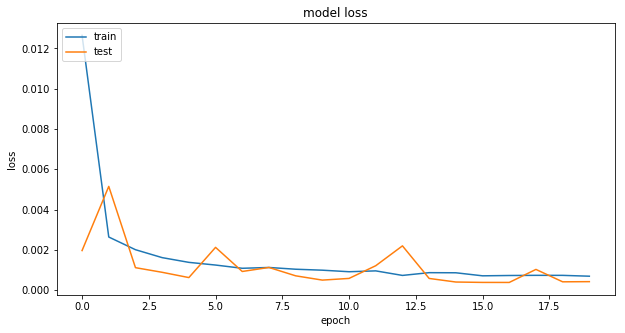

In [16]:
# Plotting learning curve
plt.figure(figsize=(10,5))
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Proxy testing
encoded_imgs_cnn = encoder_cnn.predict(np.reshape(data_test[:10, :, :, ]/255.,
                                                  (len(data_test[:10, :, :, ]), 256, 256, 1)))
decoded_imgs_cnn = autoencoder_cnn.predict(np.reshape(data_test[:10, :, :, ]/255.,
                                                  (len(data_test[:10, :, :, ]), 256, 256, 1)))

In [18]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 300))
for i in range(10):
    # display original images
    ax = plt.subplot(18, 10, i + 1)
    plt.imshow((data_test[i]/255.).reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images (one per filter)
    for j in range(encoded_imgs_cnn.shape[3]):
        ax = plt.subplot(18, 10, i + j*10 + 1 + 10)
        plt.imshow(encoded_imgs_cnn[i,:,:,j].reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(18, 10, 170 + i + 1)
    plt.imshow(decoded_imgs_cnn[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()